## M5 competition

This competition is forecasting competition, where we aim to make correct predictions for sales 28 days in the future. Or, more precisely, 28 days in public dataset and 28 days in private dataset. When one month is left before the deadline, the labels for the 28 public days will be released.

It is quite interesting that there are two competitions for the same data, the difference is in the metric and values to predict:
* in this competition we make point forecasts and the metric is Weighted Root Mean Squared Scaled Error (WRMSSE);
![](https://i.imgur.com/uqhsf3d.png)
![](https://i.imgur.com/B1hglCf.png)
* in another competition we make predictions for quantiles and the metric is Weighted Scaled Pinball Loss (WSPL)
![](https://i.imgur.com/J8XAQP4.png)
![](https://i.imgur.com/jzLckus.png)
![](https://i.imgur.com/3ihaSZO.png)

I plan to do some extensive EDA as I'm interested in this data! And then, of course, we will build some models.
There is a lot of things in this data, so I'll go step by step.


![](https://i.imgur.com/C5hASXe.png)

*Work in progress :)*

## Import libraries

In [9]:
import numpy as np
import pandas as pd
import os
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error, f1_score
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
# import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from typing import Any
from itertools import product
pd.set_option('max_rows', 500)
import re
from tqdm import tqdm
from joblib import Parallel, delayed

## Loading the data and overview

In [11]:
path = '../input/'
train_sales = pd.read_csv(f'{path}/sales_train_validation.csv')
calendar = pd.read_csv(f'{path}/calendar.csv')
submission = pd.read_csv(f'{path}/sample_submission.csv')
sell_prices = pd.read_csv(f'{path}/sell_prices.csv')

In [12]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


Not surprisingly `calender` has data about dates: for each date we get info about dayofweek/week/month/year, events and flags showing whether stores allowed purchases with SNAP food stamps. We have the data for all the dates.

In [13]:
train_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


Here we have information about item characteristics and sales for each day

In [14]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


And here we have information on sell prices for all items in all stores by weeks.submission

In [15]:
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our submission file should contain the forecast for the next 56 days (28 public, 28 private). We make predictions for each item in each store.

## Data exploration

### All info about a single item

Let's start with looking at all the data for a single item.

In [16]:
train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_001']

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
3049,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,0,0,1,2,0,4,0,0,2,2
6098,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,2,4,0,1,1,1,0,3,3
9147,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,...,1,0,0,1,0,1,0,1,2,1
12196,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2
15245,HOBBIES_1_001_TX_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18294,HOBBIES_1_001_TX_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
21343,HOBBIES_1_001_WI_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,0,0,0,0,...,0,0,0,0,0,0,1,2,1,1
24392,HOBBIES_1_001_WI_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
27441,HOBBIES_1_001_WI_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


We can see that this item (as well as all other items in fact) is sold in 10 stores in 3 states. This item belongs to `HOBBIES` category and is sold in `HOBBIES_1` department.

In [17]:
sell_prices.loc[sell_prices['item_id'] == 'HOBBIES_1_001']

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.580000000000000
1,CA_1,HOBBIES_1_001,11326,9.580000000000000
2,CA_1,HOBBIES_1_001,11327,8.260000000000000
3,CA_1,HOBBIES_1_001,11328,8.260000000000000
4,CA_1,HOBBIES_1_001,11329,8.260000000000000
...,...,...,...,...
6145173,WI_3,HOBBIES_1_001,11617,8.380000000000001
6145174,WI_3,HOBBIES_1_001,11618,8.380000000000001
6145175,WI_3,HOBBIES_1_001,11619,8.380000000000001
6145176,WI_3,HOBBIES_1_001,11620,8.380000000000001


Also we have the data about sell prices in all 10 stores.

Now, let's make some plots. I'd like to see sales over time in different shops.

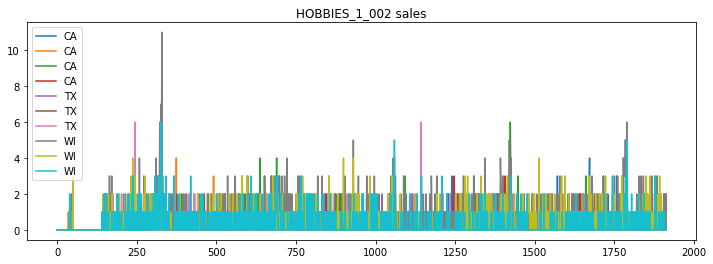

In [18]:
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 6:].values,
             label=train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 5]);
plt.title('HOBBIES_1_002 sales')
plt.legend();

Well... this doesn't look pretty. Let's make is smoother - I'll plot rolling mean over 30 days

In [ ]:
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 6:].rolling(30).mean().values,
             label=train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 5]);
plt.title('HOBBIES_1_002 sales, rolling mean 30 days')
plt.legend();

plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 6:].rolling(60).mean().values,
             label=train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 5]);
plt.title('HOBBIES_1_002 sales, rolling mean 60 days')
plt.legend();

plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 6:].rolling(90).mean().values,
             label=train_sales.loc[train_sales['item_id'] == 'HOBBIES_1_002'].iloc[i, 5]);
plt.title('HOBBIES_1_002 sales, rolling mean 90 days')
plt.legend();


So what do we see here?
* there is a definite seasonality with several peaks;
* the sales are more or less constant and quite low (max sales per day in one store is 11);
* as a result, it could be difficult to predict such low values;

In [ ]:
item_prices = sell_prices.loc[sell_prices['item_id'] == 'HOBBIES_2_001']
for s in item_prices['store_id'].unique():
    small_df = item_prices.loc[item_prices['store_id'] == s]
    plt.plot(small_df['wm_yr_wk'], small_df['sell_price'], label=s)
plt.legend()
plt.title('HOBBIES_2_001 sell prices');

What a strange situation. I suppose there were some sales with lowered prices.

### All info about a single store

Now that we know how the data about a single item looks like, let's have a look at one store.

In [ ]:
train_sales.loc[train_sales['store_id'] == 'CA_1']

We have information about sales of 3049 various items, which belong to different categories and departments.

In [ ]:
sell_prices.loc[sell_prices['store_id'] == 'CA_1']

Also we have the data about sell prices for all items in this store.

In [ ]:
ca_1_sales = train_sales.loc[train_sales['store_id'] == 'CA_1']
pd.crosstab(ca_1_sales['cat_id'], ca_1_sales['dept_id'])

This store (and I suppose other stores) have 3 categories: foods, hobbies and households, which have 2-3 departments.

In [ ]:
plt.figure(figsize=(12, 4))
for d in ca_1_sales['dept_id'].unique():
    store_sales = ca_1_sales.loc[ca_1_sales['dept_id'] == d]
    store_sales.iloc[:, 6:].sum().rolling(30).mean().plot(label=d)
plt.title('CA_1 sales by department, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

Interesting that `FOODS_1` has much higher sales than any other department.

In [ ]:
item_prices = sell_prices.loc[sell_prices['item_id'] == 'HOBBIES_2_001']
for s in item_prices['store_id'].unique():
    small_df = item_prices.loc[item_prices['store_id'] == s]
    plt.plot(small_df['wm_yr_wk'], small_df['sell_price'], label=s)
plt.legend()
plt.title('HOBBIES_2_001 sell prices');

In [ ]:
ca_1_prices = sell_prices.loc[sell_prices['store_id'] == 'CA_1']
ca_1_prices['dept_id'] = ca_1_prices['item_id'].apply(lambda x: x[:-4])


In [ ]:
plt.figure(figsize=(12, 6))
for d in ca_1_prices['dept_id'].unique():
    small_df = ca_1_prices.loc[ca_1_prices['dept_id'] == d]
    grouped = small_df.groupby(['wm_yr_wk'])['sell_price'].mean()
    plt.plot(grouped.index, grouped.values, label=d)
plt.legend(loc=(1.0, 0.5))
plt.title('CA_1 mean sell prices by dept');

We can see that prices on `HOBBIES_1` increase over time, but for other categories they are quite stable.

### All info about a single department

Now we can analyse how different items of the same department are sold in different stores.

In [ ]:
train_sales.loc[train_sales['dept_id'] == 'HOBBIES_1']

In [ ]:
train_sales.loc[train_sales['dept_id'] == 'HOBBIES_1', 'item_id'].nunique()

We can see that there are 416 unique items in this department and they are sold in all stores.

In [ ]:
sell_prices.loc[sell_prices['item_id'].str.contains('HOBBIES_1')]

In [ ]:
hobbies_1_sales = train_sales.loc[train_sales['dept_id'] == 'HOBBIES_1']
plt.figure(figsize=(12, 6))
for d in hobbies_1_sales['store_id'].unique():
    store_sales = hobbies_1_sales.loc[hobbies_1_sales['store_id'] == d]
    store_sales.iloc[:, 6:].sum().rolling(30).mean().plot(label=d)
plt.title('HOBBIES_1 sales by stores, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

We can see a definite increase of sales over time. And we can see that CA_1 and CA_3 stores have higher sales than other stores.

In [ ]:
sell_prices.head()

In [ ]:
hobbies_1_prices = sell_prices.loc[sell_prices['item_id'].str.contains('HOBBIES_1')]
plt.figure(figsize=(12, 6))
for d in hobbies_1_prices['store_id'].unique():
    small_df = hobbies_1_prices.loc[hobbies_1_prices['store_id'] == d]
    grouped = small_df.groupby(['wm_yr_wk'])['sell_price'].mean()
    plt.plot(grouped.index, grouped.values, label=d)
plt.legend(loc=(1.0, 0.5))
plt.title('HOBBIES_1 mean sell prices by store');

Not only sales grow over time, the prices also grow. We can see that there were several points of time when the price increased.

### All info about a single state

Now we can analyse how different items are sold in different stores of the same state.

In [ ]:
train_sales.loc[train_sales['state_id'] == 'CA']

In [ ]:
for col in ['item_id', 'dept_id', 'store_id']:
    print(f"{col} has {train_sales.loc[train_sales['state_id'] == 'CA', col].nunique()} unique values for CA state")

In [ ]:
ca_sales = train_sales.loc[train_sales['state_id'] == 'CA']
plt.figure(figsize=(12, 6))
for d in ca_sales['store_id'].unique():
    store_sales = ca_sales.loc[ca_sales['store_id'] == d]
    store_sales.iloc[:, 6:].sum().rolling(30).mean().plot(label=d)
plt.title('CA sales by stores, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

We can see a lot of interesting things:
* ca_3 store always has higher sales;
* ca_1 has a little increasing trend;
* ca_2 had a long decline and then had a very steep increase in sales;

In [ ]:
ca_prices = sell_prices.loc[sell_prices['store_id'].str.contains('CA')]
plt.figure(figsize=(12, 6))
for d in ca_prices['store_id'].unique():
    small_df = ca_prices.loc[ca_prices['store_id'] == d]
    grouped = small_df.groupby(['wm_yr_wk'])['sell_price'].mean()
    plt.plot(grouped.index, grouped.values, label=d)
plt.legend(loc=(1.0, 0.5))
plt.title('Mean sell prices by store in CA');

We can see that there were several points of time when the price increased.

### Aggregations over department

Now let's look at various aggregations over the data

In [ ]:
train_sales.head()

In [ ]:
plt.figure(figsize=(12, 8))
dept_grouped_sales = train_sales.groupby(['dept_id']).sum()
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.values, label=i);
plt.legend(loc=(1.0, 0.5))
plt.title('Sales by departments');

In [ ]:
plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(30).mean().values, label=i);
plt.title('Sales by department, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(60).mean().values, label=i);
plt.title('Sales by department, rolling mean 60 days')
plt.legend(loc=(1.0, 0.5));

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(90).mean().values, label=i);
plt.title('Sales by department, rolling mean 90 days')
plt.legend(loc=(1.0, 0.5));


We can see that `FOOD_3` has much higher sales than any other department.